In [23]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import platform
from pathlib import Path

In [24]:
system = platform.system()
if system == "Darwin":
    current_dir = os.path.basename(os.getcwd())
    
    if current_dir != "backend":
        os.chdir(os.path.join(os.getcwd(), "backend"))

In [25]:
tf.keras.backend.clear_session()

In [26]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # bce loss


def gan_loss(disc_generated_output):
    return loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

In [27]:
def downsample(filters, size, strides=2, apply_batchnorm=True, apply_specnorm=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    result.add(tf.keras.layers.Conv2D(filters, size, strides=strides,
                                          padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_batchnorm=True, apply_dropout=False, apply_specnorm=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()


    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                                   padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [28]:
def get_generator_arch():
    
    down_stack = [
        downsample(64, 4),
        downsample(128, 4)
    ]

    up_stack = [
        upsample(64, 4),
    ]
    
    return down_stack, up_stack

In [29]:
down_stack, up_stack = get_generator_arch()

In [30]:
# Using Lambda
def generator_loss(disc_generated_output, gen_output, target, loss_funcs):

    _gan_loss = gan_loss(disc_generated_output)

    _loss = 0
    for loss_func in loss_funcs:
        _loss += loss_func(target, gen_output)

    total_gen_loss = _gan_loss + LAMBDA*_loss

    return total_gen_loss, _gan_loss, _loss


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(
        disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [31]:
def ssim_loss(target, gen_output):
    ssim = tf.reduce_mean(tf.image.ssim(target, gen_output, 1.))
    return 1 - ssim

def sobel(img): return tf.image.sobel_edges(img)

def sobel_loss(target, gen_output):
    return tf.reduce_mean(
        tf.square(sobel(target) - sobel(gen_output)))

def l1_loss(target, gen_output):
    return tf.reduce_mean(tf.abs(target - gen_output))

In [32]:
# Check if specnorm, instancenorm, batchnorm required in the different models we will try!!
def resblock(filters, size, x, apply_specnorm=False):

    initializer = tf.random_normal_initializer(0., 0.02)

    fx = tf.keras.layers.Conv2D(
        filters, size, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    fx = tf.keras.layers.BatchNormalization()(fx)

    fx = tf.keras.layers.Conv2D(
        filters, size, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    fx = tf.keras.layers.BatchNormalization()(fx)

    out = tf.keras.layers.Add()([x, fx])
    out = tf.keras.layers.ReLU()(out)

    return out

In [33]:
class Self_Attention(tf.keras.layers.Layer):
    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # Construct the conv layers
        self.query_conv = tf.keras.layers.Conv2D(
            filters=in_dim // 2, kernel_size=1)
        self.key_conv = tf.keras.layers.Conv2D(
            filters=in_dim // 2, kernel_size=1)
        self.value_conv = tf.keras.layers.Conv2D(filters=in_dim, kernel_size=1)

        # Initialize gamma as 0
        self.gamma = tf.Variable(tf.zeros(shape=(1,)), trainable=True)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    @tf.function
    def call(self, x, batch_size=1):
        """
        inputs:
            x: input feature maps (B * C * W * H)
        returns:
            out: self-attention value + input feature
            attention: B * N * N (N is Width*Height)
        """
        m_batchsize, width, height, C = batch_size, x.shape[1], x.shape[2], x.shape[3]

        proj_query = tf.reshape(self.query_conv(
            x), (m_batchsize, -1, width * height))
        proj_query = tf.transpose(proj_query, perm=[0, 2, 1])

        proj_key = tf.reshape(self.key_conv(
            x), (m_batchsize, -1, width * height))  # B * C * N

        energy = tf.matmul(proj_query, proj_key)  # batch matrix-matrix product
        attention = self.softmax(energy)  # B * N * N
        proj_value = tf.reshape(self.value_conv(
            x), (m_batchsize, -1, width * height))  # B * C * N
        # batch matrix-matrix product
        out = tf.matmul(proj_value, tf.transpose(attention, perm=[0, 2, 1]))
        out = tf.reshape(out, (m_batchsize, width, height, C))  # B * C * W * H

        out = self.gamma * out + x
        return out, attention

In [34]:
def Generator(width, height, down_stack, up_stack, latitude=False, date=False, type='unet', attention=False):

    def unet(x):
        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        i = 0
        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = tf.keras.layers.Concatenate()([x, skip])
            if (i == 6 and attention):
                self_attn = Self_Attention(in_dim=x.shape[3])
                x, _ = self_attn(x)
            i += 1

        return x

    def resnet9(x):
        # 2 downsampling blocks
        for down in down_stack:
            x = down(x)

        if attention:
            self_attn = Self_Attention(in_dim=x.shape[3])
            x, _ = self_attn(x)

        # 9 residual blocks
        for i in range(9):
            x = resblock(128, 4, x, apply_specnorm=attention)

        # 2 upsampling blocks
        for up in up_stack:
            x = up(x)

        return x

    inputs = tf.keras.layers.Input(shape=[width, height, 1])
    if latitude:
        lat = tf.keras.layers.Input(shape=[width, height, 1])
    if date:
        dat = tf.keras.layers.Input(shape=[width, height, 1])

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (batch_size, 512, 512, 1)

    if latitude and date:
        x = tf.keras.layers.concatenate([inputs, lat, dat])
    elif latitude:
        x = tf.keras.layers.concatenate([inputs, lat])
    elif date:
        x = tf.keras.layers.concatenate([inputs, dat])
    else:
        x = inputs

    if (type == 'unet'):
        x = unet(x)
    elif (type == 'resnet9'):
        x = resnet9(x)

    x = last(x)

    ip = [inputs]
    if latitude:
        ip.append(lat)
    if date:
        ip.append(dat)

    return tf.keras.Model(inputs=ip, outputs=x)


def Discriminator(width, height, latitude=False, date=False, type='unet', attention=False):

    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[width, height, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[width, height, 1], name='target_image')
    if latitude:
        lat = tf.keras.layers.Input(shape=[width, height, 1], name='latitude')
    if date:
        dat = tf.keras.layers.Input(shape=[width, height, 1], name='date')

    if (latitude and date):
        x = tf.keras.layers.concatenate([inp, tar, lat, dat])
    elif latitude:
        x = tf.keras.layers.concatenate([inp, tar, lat])
    elif date:
        x = tf.keras.layers.concatenate([inp, tar, dat])
    else:
        x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(64, 4, apply_batchnorm=False,
                       apply_specnorm=attention)(x)
    down2 = downsample(128, 4, apply_batchnorm=True, apply_specnorm=attention)(
        down1)
    # add attention
    if (attention):
        self_attn = Self_Attention(in_dim=down2.shape[3])
        down2, _ = self_attn(down2)
    down3 = downsample(256, 4, apply_batchnorm=True, apply_specnorm=attention)(
        down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    down4 = downsample(512, 4, strides=1, apply_batchnorm=True, apply_specnorm=attention)(
        zero_pad1)  # (batch_size, 31, 31, 512)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(
        down4)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(
        zero_pad2)

    ip = [inp, tar]
    if latitude:
        ip.append(lat)
    if date:
        ip.append(dat)

    return tf.keras.Model(inputs=ip, outputs=last)

In [35]:
class DeepShadow():

    def __init__(self, width, height, down_stack, up_stack, latitude=True, date=True, loss_funcs=[l1_loss], type='unet', attention=False, model_name='deepshadow'):
        self.lat = latitude
        self.dat = date
        self.loss_funcs = loss_funcs
        self.attention = attention
        self.type = type
        self.model_name = model_name
        self.generator = Generator(
            width, height, down_stack, up_stack, latitude=self.lat, date=self.dat, type=self.type, attention=self.attention)
        self.discriminator = Discriminator(
            width, height, latitude=self.lat, date=self.dat, attention=self.attention)
        
    def compute_loss(self, test_ds):
        rmse = 0
        for test_input, test_target, _, test_latitude, test_date, _ in test_ds:

            ip = [test_input]
            if self.lat:
                ip.append(test_latitude)
            if self.dat:
                ip.append(test_date)

            prediction = self.generator(ip, training=True)
            prediction = prediction * 0.5 + 0.5
            target = test_target * 0.5 + 0.5

            rmse += tf.sqrt(tf.reduce_mean(tf.square(prediction - target)))

        return rmse / len(test_ds)
    
    def restore(self, checkpoint_path):
        g_learning = 1e-4 if self.attention else 2e-4
        d_learning = 4e-4 if self.attention else 2e-4

        # check os if mac or windows
        if os.name == 'nt':
            self.generator_optimizer = tf.keras.optimizers.Adam(
                g_learning, beta_1=0.5)
            self.discriminator_optimizer = tf.keras.optimizers.Adam(
                d_learning, beta_1=0.5)
        else:
            self.generator_optimizer = tf.keras.optimizers.legacy.Adam(
                g_learning, beta_1=0.5)
            self.discriminator_optimizer = tf.keras.optimizers.legacy.Adam(
                d_learning, beta_1=0.5)

        

        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

        checkpoint.restore(tf.train.latest_checkpoint(
            checkpoint_path)).expect_partial()

In [36]:
deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=True, date=True, loss_funcs=[ssim_loss, sobel_loss, l1_loss], type='resnet9', attention=False)
deep_shadow.restore('models/shadow')


In [37]:
### Loaded the model. Now prediction!

In [38]:
def rad2deg(rad):
    pi_on_180 = 0.017453292519943295
    return rad / pi_on_180

def num2deg(xtile, ytile, zoom):
    n = tf.math.pow(2, zoom)
    lon_deg = float(xtile) / float(n) * 360.0 - 180.0
    lat_rad = tf.math.atan(tf.math.sinh(
        3.14159265359 * (1.0 - 2.0 * float(ytile) / float(n))))
    lat_deg = rad2deg(lat_rad)
    return (lat_deg, lon_deg)

In [39]:
def load_input(path, zoom, i, j):

    # Read and decode an image file to a uint8 tensor
    filename = tf.strings.format(
        '{}/{}_{}.png', (path, i, j))
    filename = tf.strings.regex_replace(filename, '\"', "")
    input_image = tf.io.read_file(filename)
    input_image = tf.io.decode_png(input_image)[:, :, 0]

    input_image = tf.reshape(input_image, (256, 256, 1))
    input_image = tf.cast(input_image, tf.float32)

    return input_image

In [40]:
def load_input_grid(path, date, zoom, i, j):
    all_input = tf.zeros((256*3, 256*3, 1))

    for x in range(-1, 2):
        for y in range(-1, 2):
            filepath = '%s/%d_%d.png' % (path, i+y, j+x)
            if os.path.isfile(filepath):
                iinput = load_input(path, zoom, i+y, j+x)
                indices = [(xx, yy) for xx in range(256+256*x, 256+256*(x+1))
                           for yy in range(256+256*y, 256+256*(y+1))]
                indices = np.array(indices).reshape(256, 256, -1)
                all_input = tf.tensor_scatter_nd_update(
                    all_input, indices, iinput)

    (latitude, longitude) = num2deg(i, j, zoom)

    all_input = all_input[128:-128, 128:-128]
    all_lat = tf.ones((512, 512), dtype=tf.float32)
    all_lat = tf.math.scalar_mul(float(latitude), all_lat)
    all_lat = tf.reshape(all_lat, (512, 512, 1))

    if date == 'winter':
        value = 0
    elif date == 'spring' or date == 'fall':
        value = 1
    else:
        value = 2

    all_date = tf.ones((512, 512), dtype=tf.float32)
    all_date = tf.math.scalar_mul(float(value), all_date)
    all_date = tf.reshape(all_date, (512, 512, 1))

    return all_input, all_lat, all_date

In [41]:
def normalize_input(input_image, lat_image, date_image):
    input_image = (input_image / 127.5) - 1
    lat_image = ((lat_image + 90) / 90.0) - 1
    date_image = date_image - 1

    return input_image, lat_image, date_image

In [42]:
def predict_shadow(generator, path, date, zoom, i, j, lat=True, dat=True):
    input_height, input_lat, input_date = load_input_grid(
        path, date, zoom, i, j)
    input_height, input_lat, input_date = normalize_input(
        input_height, input_lat, input_date)

    input_height = np.array(input_height).reshape(1, 512, 512, 1)
    input_lat = np.array(input_lat).reshape(1, 512, 512, 1)
    input_date = np.array(input_date).reshape(1, 512, 512, 1)

    concat = [input_height]
    if lat:
        concat.append(input_lat)
    if dat:
        concat.append(input_date)

    prediction = generator(concat, training=True)
    prediction = prediction.numpy()[:, 128:-128, 128:-128, :]
    prediction = prediction.reshape(256, 256)

    input_height = input_height[:, 128:-128, 128:-128, :]
    input_height = input_height.reshape(256, 256)
    input_height = (input_height+1)*127.5

    return input_height, prediction

In [45]:
# from model node, for server, need glob. then iterate over files of height rasters.

path = './data/served/raster/A_rasters'
date = 'summer'
zoom = 16
I = 16816
J = 24356

input_height, prediction = predict_shadow(deep_shadow.generator,
    path, date, zoom, I, J, lat=True, dat=True)

In [134]:
# prediction = tf.cast(prediction, tf.float32)
# prediction = tf.expand_dims(prediction, 0)
# prediction = tf.expand_dims(prediction, -1)

In [52]:
# Extract [0, :, :, 0]
arr = prediction

# Normalize if needed (OpenCV requires 0–255 uint8)
arr_min, arr_max = float(arr.min()), float(arr.max())
if arr_max > arr_min:
    arr_norm = (arr - (-1.0)) / (1.0 - (-1.0))
else:
    arr_norm = np.zeros_like(arr)

sum_var = np.sum(arr_norm[input_height != 255] * 255)
count_valid = np.sum(input_height != 255)


print(sum_var, count_valid, sum_var / count_valid)

4743.677 5593 0.848145316969873


In [53]:
arr_norm

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.4437904e-06,
        6.8545341e-07, 1.4901161e-07],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.0203333e-05,
        3.5762787e-07, 8.9406967e-07],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.0696392e-05,
        3.2782555e-07, 5.7190657e-05],
       ...,
       [0.0000000e+00, 5.7816505e-06, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [136]:
arr_min, arr_max = float(arr.min()), float(arr.max())
if arr_max > arr_min:
    arr_norm = (arr - arr_min) / (arr_max - arr_min)
else:
    arr_norm = np.zeros_like(arr)

In [137]:
print(arr.min(), arr.max()    )

-0.99984956 -0.99941087


In [125]:
arr_norm
# 720 for summer
# 540 for spring/fall
# 360 for winter

(arr_norm * 720).mean()



292.4297

In [23]:
colors = [(1, 1, 1), (254/255,204/255,92/255), (253/255,141/255,60/255), (240/255,59/255,32/255), (189/255,0,38/255)]
_cmap = LinearSegmentedColormap.from_list('colorscale', colors, N=100)

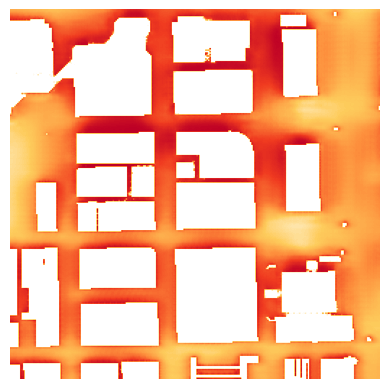

In [24]:
plt.imshow(prediction[0, :, :, 0], cmap=_cmap)
plt.axis('off');

In [25]:
prediction[0, :, :, 0]

<tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[-2.43105292e-01, -2.52147198e-01, -2.52395898e-01, ...,
        -3.39593470e-01, -3.03111285e-01, -2.64463603e-01],
       [-1.29602954e-01, -1.41892001e-01, -1.36073291e-01, ...,
        -2.94823289e-01, -2.35335603e-01, -2.01287389e-01],
       [ 6.24875538e-05, -3.01030912e-02, -2.22933982e-02, ...,
        -2.33401626e-01, -1.64815381e-01, -1.21310376e-01],
       ...,
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -3.25745583e-01, -3.04692209e-01, -2.96955377e-01],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -3.19401503e-01, -3.07644039e-01, -3.01859468e-01],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -3.14469546e-01, -3.02604437e-01, -3.13083917e-01]], dtype=float32)>

In [ ]:
def run_shadow_model(input_dir, season, output_dir):

    tf.keras.backend.clear_session()
    down_stack, up_stack = get_generator_arch()

    deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=True, date=True, loss_funcs=[ssim_loss, sobel_loss, l1_loss], type='resnet9', attention=False)
    deep_shadow.restore('models/shadow')

    in_dir = Path("./data/served/raster/" + input_dir)
    out_dir = Path("./data/served/raster/" + output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    date = season
    zoom = 16

    out_dir.mkdir(parents=True, exist_ok=True)

    for png_path in sorted(in_dir.glob("*.png")):
        stem = png_path.stem  # "16813_24353"
        try:
            I_str, J_str = stem.split("_")
            I = int(I_str)
            J = int(J_str)
        except ValueError:
            print(f"Skipping invalid name: {png_path.name}")
            continue

        print(f"[Predicting] I={I}, J={J}")

        _, prediction = predict_shadow(
            deep_shadow.generator,
            str(in_dir),     # the dir path where rasters live
            date,
            zoom,
            I,
            J,
            lat=True,
            dat=True
        )

        # Extract [0, :, :, 0]
        arr = prediction

        # Normalize if needed (OpenCV requires 0–255 uint8)
        arr_min, arr_max = float(arr.min()), float(arr.max())
        if arr_max > arr_min:
            arr_norm = (arr - (-1.0)) / (1.0 - (-1.0))
        else:
            arr_norm = np.zeros_like(arr)

        print(arr_norm.min(), arr_norm.max())
        img = (arr_norm * 255).astype("uint8")

        out_path = str(out_dir / f"{stem}.png")

        # ---- Save with OpenCV ----
        cv2.imwrite(out_path, img)

        print(f"Saved: {out_path}")

In [54]:
256*256

65536

In [21]:
# cv2 read an image
img = cv2.imread('./data/served/raster/A_shadow/16816_24354.png', cv2.IMREAD_GRAYSCALE)

# plot img
img.min(), img.max()

(42, 249)